In [64]:
import os
from os import path
import numpy as np
import nibabel as nib
from tqdm import tqdm
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from glob import glob
import random
from torchvision import transforms
import torch


In [65]:
class ImagePair(object):
    def __init__(self, number, root_dir='data'):
        self._number = number
        self.path = root_dir + "/brain_simulated_t1w_mri"
        self.img_fname = "23-Aug-2021_Ernst_labels_{:06d}_" \
                         "3T_T1w_MPR1_img_act_1_contrast_1".format(self._number)

    def LR_HR_fnames(self):
        LR_suff = "_Res_2_2_2_img.nii.gz"
        LRf = path.join(self.path, 'LR', self.img_fname + LR_suff)
        HR_suff = "_Res_1_1_2_img.nii.gz"
        HRf = path.join(self.path, 'HR', self.img_fname + HR_suff)
        return LRf, HRf

    def img(self):
        LR_fname, HR_fname = self.LR_HR_fnames()
        self.LR = nib.load(LR_fname)
        self.HR = nib.load(HR_fname)
        img_pair = {
            'LR': self.LR.get_fdata(),
            'HR': self.HR.get_fdata()
        }
        return img_pair

    def info(self):
        img_info = {
            'LR': self.LR.header,
            'HR': self.HR.header
        }
        return img_info

In [79]:
def data_split(dataset, split=[.7,.15,.15], numslices = 50, root_dir='data',
               randomseed = 7886462529168327085):
    random.seed(randomseed)
    path   = root_dir + "/brain_simulated_t1w_mri/HR/"
    fnames = glob(path + "*.nii.gz")
    ids    = sorted(list(map(int, [(fnames[i][-60:-54]) for i in range(len(fnames))])))
    random.shuffle(ids)

    split1 = int(np.floor(split[0]*len(ids)))
    split2 = split1+int(np.floor(split[1]*len(ids)))
    split3 = split2+int(np.floor(split[2]*len(ids)))

    if dataset == 'training':
        ids_split = ids[:split1]
    elif dataset == 'validation':
        ids_split = ids[split1:split2]

    samples = list()
    for num in tqdm(ids_split, desc='Load {} set\t'.format(dataset)):
        data = ImagePair(num, root_dir=root_dir)
        img_pair = data.img()
        LR, start_idx = slice_middle(img_pair['LR'], numslices=numslices)
        HR, _ = slice_middle(img_pair['HR'], numslices=numslices)
        for i in range(numslices):
            min_val, max_val = np.percentile(HR[:,:,i], (1, 99))
            LRi = ((LR[:,:,i].astype(float) - min_val) /
                   (max_val - min_val)).clip(0, 1).astype(np.float32)
            HRi = ((HR[:,:,i].astype(float) - min_val) /
                   (max_val - min_val)).clip(0, 1).astype(np.float32)
            slice_pair = {
                'LR': LRi,
                'HR': HRi
            }
            sample = {
                'img': slice_pair,
                'id': num,
                'slice': i+start_idx
            }
            samples.append(sample)
    return samples

def slice_middle(img, numslices):
    diff = (img.shape[2]-numslices)/2
    img = img[:,:,int(np.ceil(diff)):img.shape[2]-int(np.floor(diff))]
    return img, int(np.ceil(diff))

In [80]:
class ImagePairDataset(Dataset):
    def __init__(self, dataset, root_dir='data', transform=None):
        self._root_dir = root_dir
        self.transform = transform

        self._imgs = data_split(dataset,
                                split = [.7,.15,.15],
                                root_dir=root_dir,
                                )
        self._idcs = np.arange(len(self._imgs))

    def __len__(self):
        return len(self._idcs)

    def __getitem__(self, idx):

        img_idx = self._idcs[idx]
        img_pair = self._imgs[img_idx]

        sample = {'LR': img_pair['img']['LR'],
                  'HR': img_pair['img']['HR'],
                  'id': 'Im_{}-Slc_{}'.format(img_pair['id'], img_pair['slice']),
                  }

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self):
        self.fixed_conversion = torch.from_numpy

    def __call__(self, sample):
        LR = sample['LR']
        HR = sample['HR']
        try:
            LR = self.fixed_conversion(LR)
            HR = self.fixed_conversion(HR)
        except ValueError:
            LR = self.fixed_conversion(np.ascontiguousarray(LR))
            HR = self.fixed_conversion(np.ascontiguousarray(HR))
        ret = {'LR': LR,
               'HR': HR,
               'id': sample['id']}
        return ret

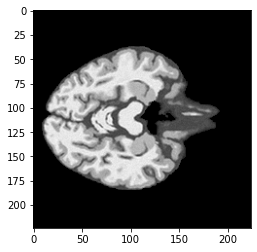

In [81]:
num = 100206
img = ImagePair(number=num, root_dir='data')
slice = img.img()['HR'][:,:,25]
plt.imshow(slice, cmap='gray')
# print(img.info()['HR'])

In [82]:
transform = transforms.Compose([
    ToTensor(),
])

tra_set = ImagePairDataset('training', transform=transform)
val_set = ImagePairDataset('validation', transform=transform)

Load validation set	: 100%|████████████████████████████████████████| 30/30 [00:03<00:00,  8.02it/s]


Length of training set: 	7000
Length of validation set: 	1500


(-0.5, 223.5, 223.5, -0.5)

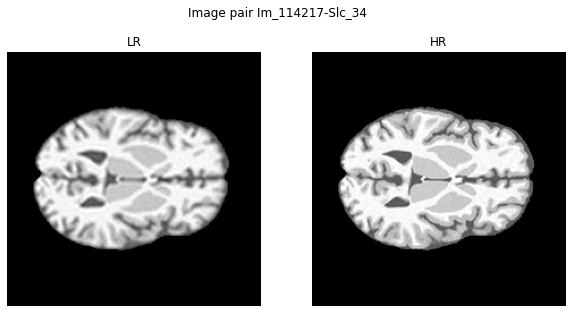

In [83]:
print('Length of training set: \t{}\nLength of validation set: \t{}'
      .format(len(tra_set),len(val_set)))

num = 25
sample = tra_set[num]
title = 'Image pair {}'.format(sample['id'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.set_facecolor('white')
fig.suptitle(title)
ax1.imshow(sample['LR'],cmap='gray')
ax1.set_title('LR')
ax1.axis('off')
ax2.imshow(sample['HR'],cmap='gray')
ax2.set_title('HR')
ax2.axis('off')